# Evaluation of YOLOv7

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import PIL.Image as Image
from pathlib import Path
from tools.evaluation import plot_ap, plot_precision_recall_curves, parse_evaluation_results, \
    measure_inference_time, init_metrics_json, add_model_metrics, save_json, plot_pr, plot_f1_curves


## Load Evaluation Data

In [3]:
kitti_classes = {'Car': 0, 
                 'Pedestrian': 1, 
                 'Van': 2, 
                 'Cyclist': 3, 
                 'Truck': 4, 
                 'Misc': 5, 
                 'Tram': 6, 
                 'Person_sitting': 7}

In [4]:
model_name = 'yolov7'
result_path = Path('../results/yolov7_last')

# Parse the result file
detections, ap_scores, precisions, recalls = parse_evaluation_results(result_path, kitti_classes, model_name)

['mAP_yolov7_split1.txt', 'mAP_yolov7_split2.txt', 'mAP_yolov7_split3.txt'] are found!


In [11]:
%matplotlib inline

## Detection Results on Test Dataset

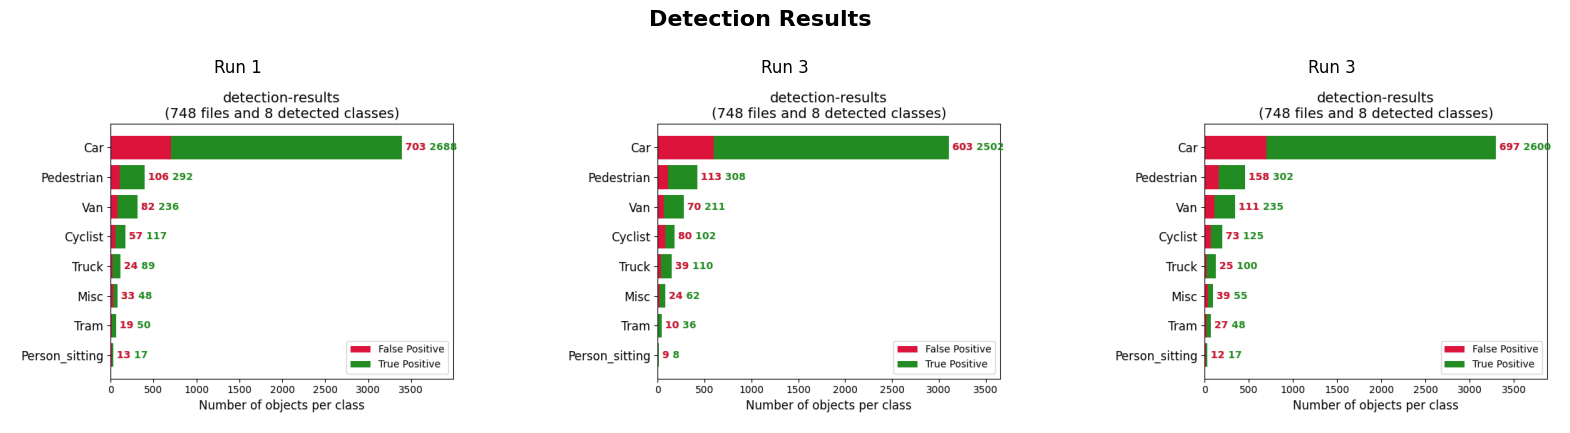

In [6]:
plt.figure(figsize=(20,5))
plt.suptitle("Detection Results", fontsize=16, fontweight='bold')
plt.subplot(1,3,1)
plt.title('Run 1')
plt.imshow(Image.open('assets/split_1/detection-results-info.png'))
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Run 3')
plt.imshow(Image.open('assets/split_2/detection-results-info.png'))
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Run 3')
plt.imshow(Image.open('assets/split_3/detection-results-info.png'))
plt.axis('off')

plt.show()

## Precision and Recall

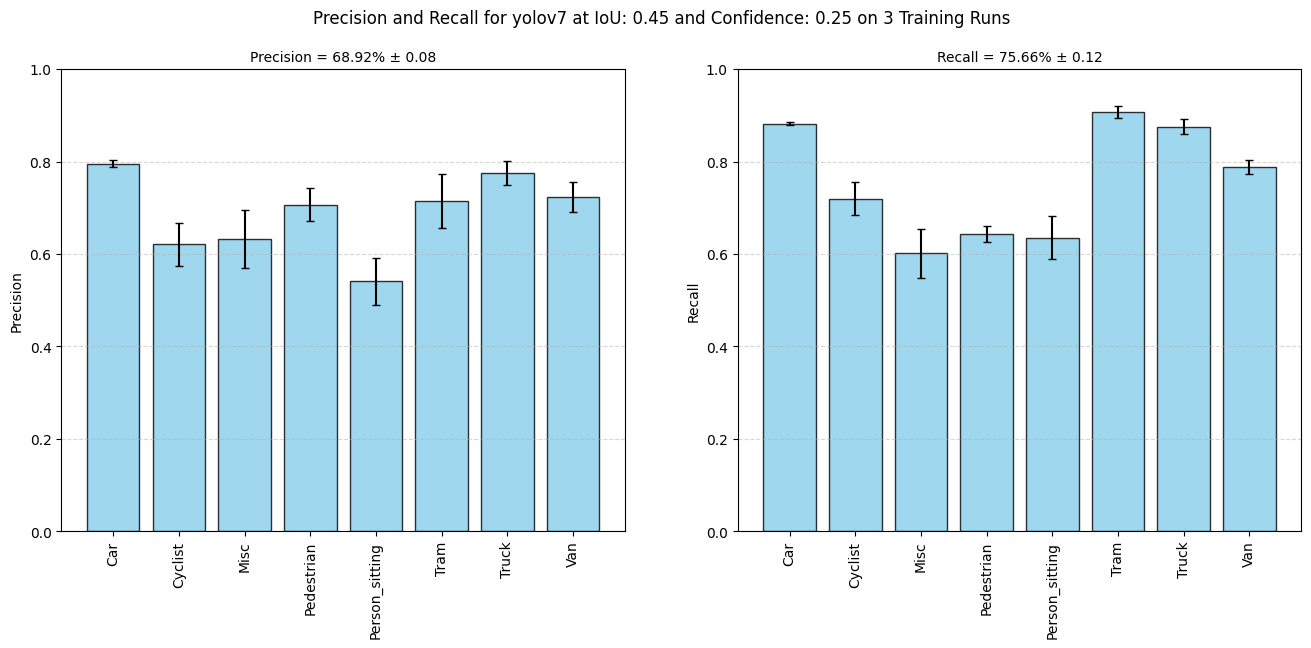

In [5]:
plot_pr(detections, model_name=model_name, iou_thres=0.45, conf_thres=0.25)

## Average Precision at IoU 0.5

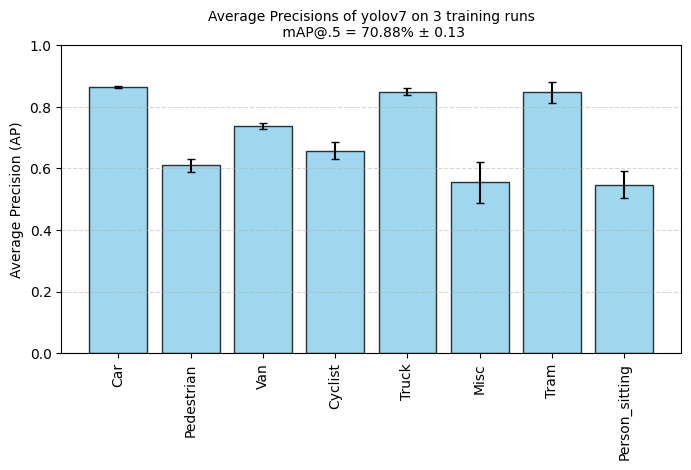

In [12]:
# Plot average precision of all the classes
plot_ap(ap_scores, model_name=model_name)

## Precision Recall Curve

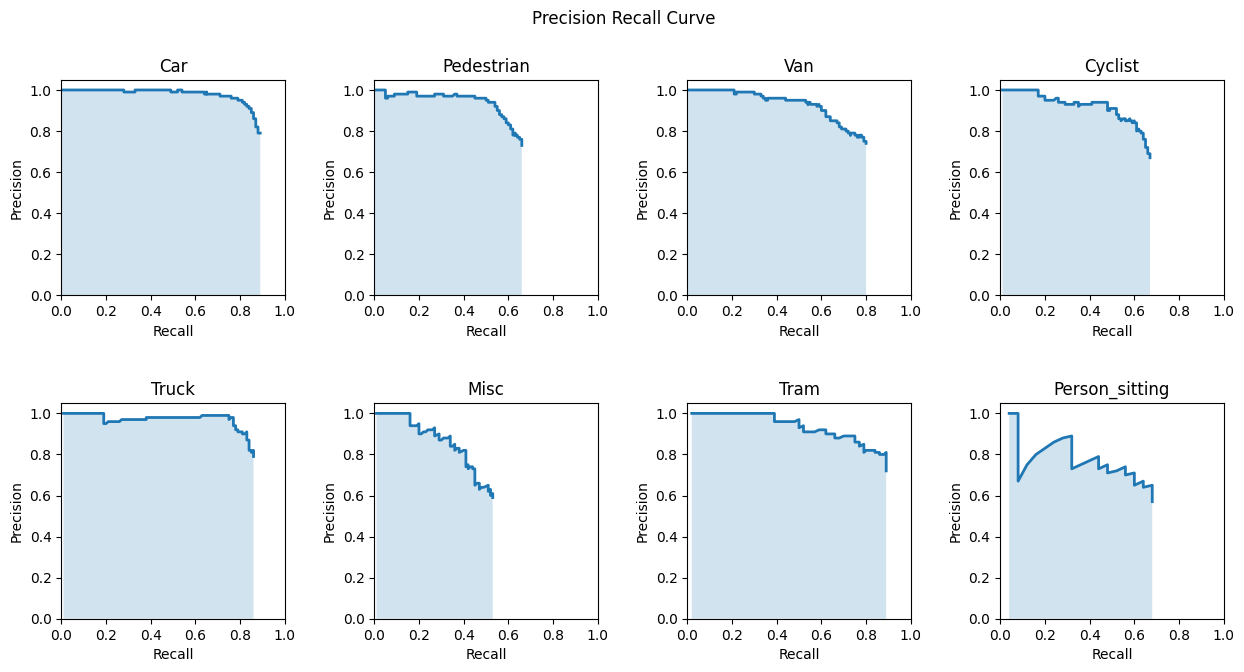

In [63]:
# Plot precision recall curve of each class
# show Area Under Curve (AUC), separate each class
# TEST: Argument 'force_single_result' is for debugging purpose to show only the first evaluation result,
# although there are multiple evaluation results for a model
plot_precision_recall_curves(precisions, recalls, show_auc=True, separate=True, force_single_result=True)           

### Join precision recall curves of each class in a plot 

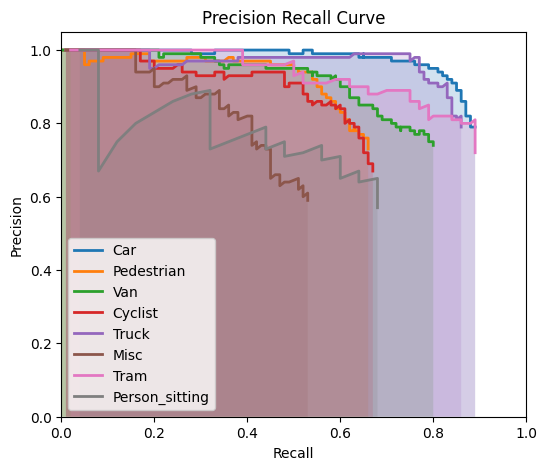

In [14]:
# Plot precision recall curve of each class
plot_precision_recall_curves(precisions, recalls, show_auc=True, separate=False, force_single_result=True)     # show Area Under Curve (AUC) & join all curves of each vlass

### Precision recall curves of each class on 3 training runs

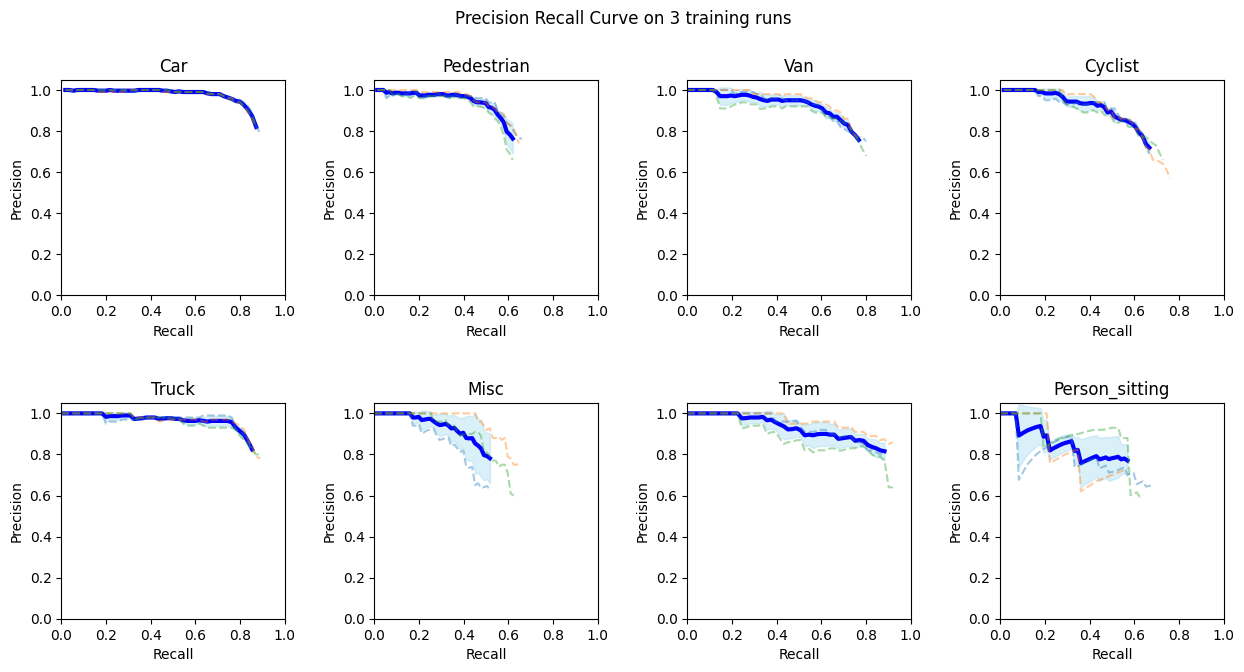

In [16]:
# Plot precision recall curve of each class
plot_precision_recall_curves(precisions, recalls, show_auc=False, separate=True)     # show Area Under Curve (AUC) & join all curves of each vlass

### Precision recall curves of each class with the Area Under Curve (AUC)

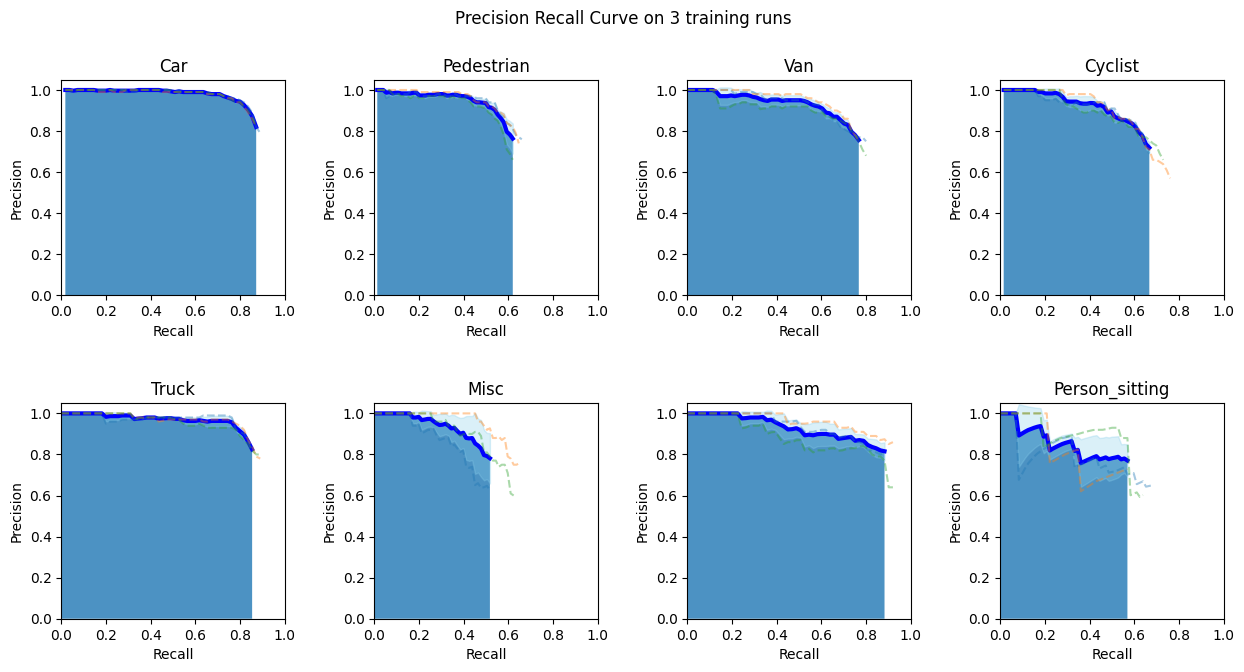

In [17]:
plot_precision_recall_curves(precisions, recalls, show_auc=True, separate=True)     

In [64]:
# plot_f1_curves(precisions, recalls)     

## Load Model

In [18]:
# Add yolov7 package to the python path
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))  # Adjust path if necessary
yolov7_path = os.path.join(project_root, 'yolov7')
sys.path.append(yolov7_path)

In [19]:
base_dir = Path('../../')

ckpt = torch.load(base_dir / "yolov7" / "yolov7-tiny-kitti.pt", weights_only=False)
model = ckpt["model"]
model.eval() 
print()

## Inference Time

In [20]:
cpu_device = torch.device('cpu' )
gpu_device = torch.device('cuda:0') if torch.cuda.is_available() else None

In [24]:
dummy_input = torch.randn(1, 3, 640, 640).to(cpu_device).half()  # (batch_size, channels, height, width)

ckpt = torch.load(base_dir / "yolov7" / "yolov7-tiny-kitti.pt", map_location=cpu_device, weights_only=False)
model = ckpt["model"]
model.eval()

result = measure_inference_time(model, (1,3,224,224), device=cpu_device, iteration=10, half=True)
inference_time_cpu = result.mean

print(f'Mean Inference Time on CPU: {inference_time_cpu:.2f} s')

Mean Inference Time on CPU: 0.82 s


In [25]:
if gpu_device is not None:
    dummy_input = torch.randn(1, 3, 640, 640).to(gpu_device).half()  # (batch_size, channels, height, width)
    
    ckpt = torch.load(base_dir / "yolov7" / "yolov7-tiny-kitti.pt", map_location=gpu_device, weights_only=False)
    model = ckpt["model"]
    model.eval()
    
    result = measure_inference_time(model, (1,3,224,224), device=gpu_device, iteration=10, half=True)
    inference_time_gpu = result.mean
    
    print(f'Mean Inference Time on GPU: {result.mean * 1000:.2f} ms')
else:
    print("No GPU available, using CPU instead!")

Mean Inference Time on GPU: 11.93 ms


## Model Size

In [23]:
from torchinfo import summary

dummy_input = torch.randn(1, 3, 640, 640).to('cuda').half()
model_info = summary(model, input_data=dummy_input)    
print(f"Total number of Parameters: {model_info.total_params / 1e6:.2f} M, {model_info.to_megabytes(model_info.total_param_bytes):.2f} MB")    

Total number of Parameters: 6.03 M, 12.07 MB


## Save Results in JSON

In [26]:
metrics_result_path = Path("../results")

# Initialize json file
data = init_metrics_json(metrics_result_path)
data

{'model': {}, 'hardware': {}}

In [27]:
cpu_name = "Intel(R) Core(TM) i7-11800H @ 2.30GHz"
print(f"CPU name: {cpu_name}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)  # 0 for the first GPU
    print(f"CUDA GPU name: {gpu_name}")

CPU name: Intel(R) Core(TM) i7-11800H @ 2.30GHz
CUDA GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [28]:
# Set new hardware description
data["hardware"]["cpu_name"] = cpu_name
data["hardware"]["gpu_name"] = gpu_name

In [29]:
# Add new model evaluation metrics to the existing data
add_model_metrics(
    data, 
    model_name=model_name,                                                  # Model name
    inference_time_cpu=inference_time_cpu,                                  # Inference time on CPU
    inference_time_gpu=inference_time_gpu,                                  # Inference time on GPU
    num_parameters=model_info.total_params,                                 # Example number of parameters
    memory_usage=model_info.to_megabytes(model_info.total_param_bytes)      # Memory usage in MB
)

data

{'model': {'yolov7': {'inference_time_gpu': 0.011932749999687076,
   'inference_time_cpu': 0.8197850699994887,
   'num_parameter': 6033930,
   'memory_usage': 12.06786}},
 'hardware': {'cpu_name': 'Intel(R) Core(TM) i7-11800H @ 2.30GHz',
  'gpu_name': 'NVIDIA GeForce RTX 3050 Laptop GPU'}}

In [30]:
# Save the changes
save_json(data, metrics_result_path / "metrics.json")